In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.linear_model import LogisticRegression
import seaborn as sns

ModuleNotFoundError: No module named 'pandas'

In [ ]:
# Get data
# for some reason pandas reads some str values as float
dtype = {
    'age': np.int64
}
binary_features = ['gender', 'diabetes', 'hypertension', 'hypercholesterolemia', 'smoking', 'Lacunes_Presence', 'CMB_Presence', 'fazekas_cat']            
for n in binary_features:
    dtype[n] = str

data = pd.read_csv("main.csv", sep=",", dtype=dtype)

In [ ]:
# Check data
data.head()

,age,gender,dementia,dementia_all,diabetes,hypertension,hypercholesterolemia,smoking,EF,PS,Global,Lacunes_Presence,CMB_Presence,Fazekas,fazekas_cat,study_Name,SVD Simple Score,SVD Amended Score,lac_count
0,54,male,no,no,no,No,Yes,Quit,0.620000,0.220000,0.746667,Absent,Absent,1,0 to 1,Geriatric Population Study,NaN,NaN,Zero
1,70,male,no,no,no,Yes,Yes,Quit,NaN,NaN,NaN,Present,Absent,3,2 to 3,Cerebrovascular Study,2.0,5.0,3 to 5
2,58,female,no,no,no,No,Yes,NaN,0.290000,0.050000,0.196667,Absent,Absent,0,0 to 1,Geriatric Population Study,0.0,0.0,Zero
3,58,male,no,no,no,Yes,Yes,Smoker,0.510000,0.210000,0.626667,Absent,Absent,1,0 to 1,ASPS Family Study,0.0,0.0,Zero
4,53,male,no,no,no,No,No,Smoker,-0.327058,0.184665,-0.260674,Absent,Absent,1,0 to 1,Cerebrovascular Study,0.0,1.0,Zero


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1830 entries, 0 to 1829
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   1830 non-null   int64  
 1   gender                1830 non-null   object 
 2   dementia              1796 non-null   object 
 3   dementia_all          1830 non-null   object 
 4   diabetes              1830 non-null   object 
 5   hypertension          1830 non-null   object 
 6   hypercholesterolemia  1830 non-null   object 
 7   smoking               925 non-null    object 
 8   EF                    1624 non-null   float64
 9   PS                    1564 non-null   float64
 10  Global                1524 non-null   float64
 11  Lacunes_Presence      1830 non-null   object 
 12  CMB_Presence          1830 non-null   object 
 13  Fazekas               1830 non-null   int64  
 14  fazekas_cat           1830 non-null   object 
 15  study_Name           

In [ ]:
print("Mean age:", data["age"].describe()['mean'])
print("Null values:\n", data.isnull().sum())

Mean age: 65.97213114754098
Null values:
 age                       0
gender                    0
dementia                 34
dementia_all              0
diabetes                  0
hypertension              0
hypercholesterolemia      0
smoking                 905
EF                      206
PS                      266
Global                  306
Lacunes_Presence          0
CMB_Presence              0
Fazekas                   0
fazekas_cat               0
study_Name                0
SVD Simple Score        673
SVD Amended Score       673
lac_count                 0
dtype: int64


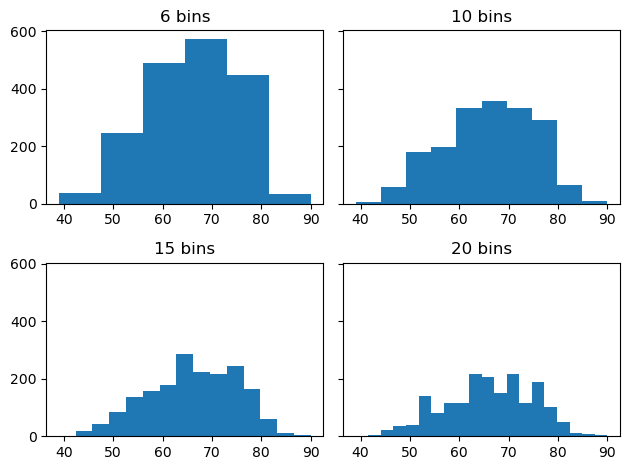

In [ ]:
bins = [6, 10, 15, 20]
fig, axs = plt.subplots(2, 2, sharey=True, tight_layout=True)
i = 0
for ax in axs:
    for a in ax:
        a.hist(data['age'], bins=bins[i])
        a.set_title(f"{bins[i]} bins")
        i += 1

# Data preprocessing

In [ ]:
# Drop null values from dementia
data.dropna(subset = ['dementia'], inplace=True)

# Smoking contains null values, set these to None
data.loc[:, 'smoking'].fillna('None', inplace=True)

#Drop unused labels
data = data.drop(columns=['EF', 'PS', 'Global', 'Fazekas', 'SVD Simple Score', 'SVD Amended Score', 'lac_count'])

# Binaries from yes/no to 1/0
for n in binary_features:
    if n == 'smoking':
        data['smoking'] = data['smoking'].replace({'Quit':0,'Smoker':1, 'None': 0}).astype(int)
    elif n == 'gender':
        data['gender'] = data['gender'].replace({'female': 0, 'male': 1})
    elif n == 'fazekas_cat':
        data['fazekas_cat'] = data['fazekas_cat'].replace({'0 to 1':0,'2 to 3':1}).astype(int)
    data[n] = data[n].replace({'No':0,'Yes':1, 'no':0,'yes':1, 'Absent':0,'Present':1}).astype(int)
data['dementia'] = data['dementia'].replace({'no': 0, 'yes': 1})
data.columns

Index(['age', 'gender', 'dementia', 'dementia_all', 'diabetes', 'hypertension',
       'hypercholesterolemia', 'smoking', 'Lacunes_Presence', 'CMB_Presence',
       'fazekas_cat', 'study_Name'],
      dtype='object')

In [ ]:
features = ['age', 'gender', 'diabetes', 'hypertension', 'hypercholesterolemia', 'smoking', 'Lacunes_Presence', 'CMB_Presence', 'fazekas_cat']   
x = data[features]
y = data['dementia']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(x_train, y_train)

y_pred = rfc.predict(x_test)

# Set up k-fold cross-validation, k = 5
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform k-fold cross-validation on the training set. Runs the model training and evaluation for each fold
cv_results = cross_val_score(rfc, x_train, y_train, cv=kf)

y_train_pred = rfc.predict(x_train)

# Calculate training accuracy and training error
train_accuracy = accuracy_score(y_train, y_train_pred)
train_error = 1 - train_accuracy

accuracy = accuracy_score(y_test, y_pred)
validation_error = 1 - accuracy # = test error

# Print the cross-validation scores for each fold and the mean score
print("Cross-validation scores for each fold: ", cv_results)
print("Mean cross-validation score: ", cv_results.mean())
print(f"Training Accuracy: {100 * train_accuracy:.2f}%, Training Error: {100 * train_error:.2f}%")
print(f"Validation Accuracy: {100 * accuracy:.2f}%, Validation Error: {100 * validation_error:.2f}%")

classification_rep = classification_report(y_test, y_pred)
print(classification_rep)

Cross-validation scores for each fold:  [0.94047619 0.96031746 0.92031873 0.96414343 0.94023904]
Mean cross-validation score:  0.9450989692025548
Training Accuracy: 98.49%, Training Error: 1.51%
Validation Accuracy: 94.81%, Validation Error: 5.19%
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       513
           1       0.38      0.12      0.18        26

    accuracy                           0.95       539
   macro avg       0.67      0.55      0.57       539
weighted avg       0.93      0.95      0.93       539



# Logistic Regression

In [ ]:
clf = LogisticRegression(random_state=0)
clf.fit(x_train, y_train)

y_pred_clf = clf.predict(x_test)

clf_accuracy = accuracy_score(y_test, y_pred_clf)
clf_validation_error = 1 - clf_accuracy # = test error

# Set up k-fold cross-validation, k = 5. Shuffles data before splitting to ensure randomness.
k_f = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform k-fold cross-validation on the training set
cvresults = cross_val_score(rfc, x_train, y_train, cv=k_f)

y_train_pred = clf.predict(x_train)

train_accuracy = accuracy_score(y_train, y_train_pred)
train_error = 1 - train_accuracy

# Print the cross-validation scores for each fold and the mean score
print("Cross-validation scores for each fold: ", cvresults)
print("Mean cross-validation score: ", cvresults.mean())
print(f"Training Accuracy: {100 * train_accuracy:.2f}%, Training Error: {100 * train_error:.2f}%")
print(f"Validation Accuracy: {100 * clf_accuracy:.2f}%, Validation Error: {100 * clf_validation_error:.2f}%")

clf_classification_rep = classification_report(y_test, y_pred_clf, zero_division=0)
print(clf_classification_rep)

Cross-validation scores for each fold:  [0.94047619 0.96031746 0.92031873 0.96414343 0.94023904]
Mean cross-validation score:  0.9450989692025548
Training Accuracy: 95.62%, Training Error: 4.38%
Validation Accuracy: 95.18%, Validation Error: 4.82%
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       513
           1       0.00      0.00      0.00        26

    accuracy                           0.95       539
   macro avg       0.48      0.50      0.49       539
weighted avg       0.91      0.95      0.93       539



/opt/software/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/software/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/software/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Result analysis

In [ ]:
all = len(data.loc[data['dementia']==1])
print(f"Dementia in all data: {all}")
print(f"Dementia in test data: {len(y_test.loc[y_test == 1])}")
print(f"Dementia in train data:{len(y_train.loc[y_train == 1])}")
per = all/len(data)*100
print(f"Dementia percentage: {per:.2f}%")

Dementia in all data: 81
Dementia in test data: 26
Dementia in train data:55
Dementia percentage: 4.51%


## Confusion matrix

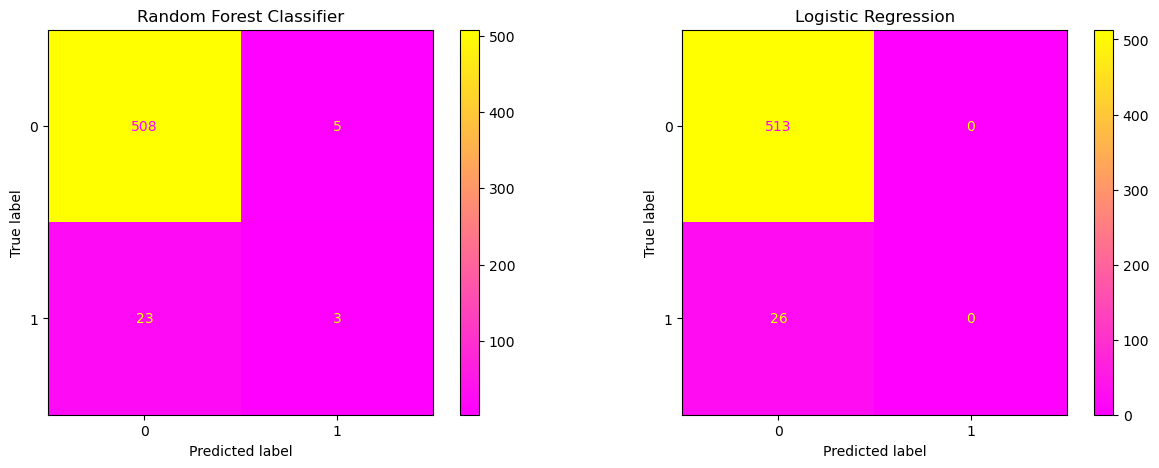

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axs[0], cmap='spring')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_clf, ax=axs[1], cmap='spring')
axs[0].set_title('Random Forest Classifier')
axs[1].set_title('Logistic Regression')
plt.show()

## Feature Importances
This shows the correlation of features to dementia

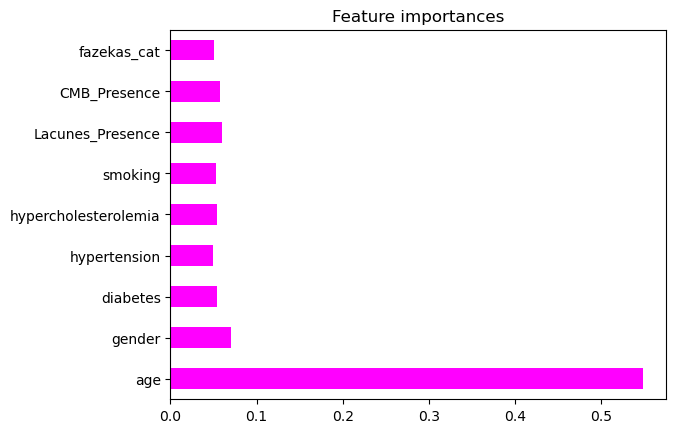

In [ ]:
pd.Series(rfc.feature_importances_, index=x.columns).plot(kind='barh', title='Feature importances', colormap='spring')
plt.show()

## Tree

In [ ]:
estimator = rfc.estimators_[5]

from sklearn.tree import export_graphviz

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

IndexError: index 1 is out of bounds for axis 0 with size 1

# Testing parameters to better the model

In [ ]:
for i in ['sqrt', 'log2']:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, max_features=i)
    rfc.fit(x_train, y_train)

    y_pred = rfc.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Prediction accuracy: {100*accuracy:.2f}%")
    classification_rep = classification_report(y_test, y_pred)
    print(classification_rep)

In [ ]:
for i in [20, 50, 100]:
    rfc = RandomForestClassifier(n_estimators=i, random_state=42)
    rfc.fit(x_train, y_train)

    y_pred = rfc.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Prediction accuracy: {100*accuracy:.2f}%")
    classification_rep = classification_report(y_test, y_pred)
    print(classification_rep)